In [27]:
import os
import sys
sys.path.append('/home/shanwibo/Capstone-TamTanai')

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from src.main import LegalAssistant

In [28]:
sns.set_theme()

In [29]:
n_documents = 1

if n_documents == 1:
    max_input_tokens = 8192
elif n_documents <= 2:
    max_input_tokens = 8192 * 2
else:
    max_input_tokens = 8192 * 4

legal_assistant = LegalAssistant(
    max_input_tokens=max_input_tokens,
    top_p=0.9,
    temperature=0.1,
    repetition_penalty=1.1,
    max_new_tokens=512
)

----------using 4*GPUs----------


Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


# New Test Dataset 1

In [30]:
import ast
from rouge_score import rouge_scorer
from transformers import AutoTokenizer
from local_bert_scorer import LocalBERTScorer

In [31]:
MODEL_DIR = '/project/lt200301-edubot/Capstone-TamTanai/models'
LOG_DIR = '/project/lt200301-edubot/Capstone-TamTanai/logs'


def find_best_model(model_name):
    log_path = os.path.join(LOG_DIR, f'{model_name}.csv')
    log = pd.read_csv(log_path)
    step = int(log.iloc[log['eval_loss'].argmin()]['step'])
    return os.path.join(MODEL_DIR, model_name, f'checkpoint-{step}')

In [32]:
model_type = '/project/lt200301-edubot/bert_score/models/microsoft/deberta-xlarge-mnli'
bert_scorer = LocalBERTScorer(model_type=model_type, num_layers=40)

In [33]:
model_name = 'typhoon2-qwen2.5-7b-instruct-finetune-dataset-v1-exam-thailegal-with-v1+exam+thailegal-validation-set'
model_path = find_best_model(model_name)

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [15]:
def run_evaluation(result_path):
    df = pd.read_csv(result_path)
    # df['retrieval_result'] = df['retrieval_result'].apply(ast.literal_eval)
    answers = df['answer'].tolist()
    generation_results = df['generation_result'].tolist()
    
    precision, recall, f1 = bert_scorer.score(generation_results, answers, verbose=True, batch_size=8)
    #print('\nBert Score')
    print("average time:", df["processing_time"].mean())
    print(f'Precision: {precision.mean().item()}')
    print(f'Recall:    {recall.mean().item()}')
    print(f'F1:        {f1.mean().item()}')

    tokenizer.model_max_length = 1000000000
    rouge = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
    for answer, generation_result in tqdm(zip(answers, generation_results), total=len(answers)):
        scores = scorer.score(answer, generation_result)
        for k in rouge:
            rouge[k].append(scores[k].fmeasure)
    print('\nRouge')
    for k in rouge:
        print(f'{k}: {np.mean(rouge[k])}')

In [16]:
run_evaluation('/project/lt200301-edubot/Capstone-TamTanai/inference_result/inference_end_to_end_n_documents=1_new_testdataset_1.csv')

calculating scores...
computing bert embedding.


100%|██████████| 97/97 [00:54<00:00,  1.78it/s]


computing greedy matching.


100%|██████████| 52/52 [00:00<00:00, 100.25it/s]


done in 55.00 seconds, 7.51 sentences/sec
average time: 41.90273767002558
Precision: 0.8567109704017639
Recall:    0.8791764974594116
F1:        0.8669094443321228


100%|██████████| 413/413 [00:00<00:00, 586.48it/s]


Rouge
rouge1: 0.6682841948111392
rouge2: 0.6024955816445402
rougeL: 0.6275994616725079


# New Test Dataset 2 end to end evaluation 

In [39]:
def run_evaluation(result_path):
    df = pd.read_csv(result_path)
    df_0 = df[0:100]
    df_1 = df[100:]
    # df['retrieval_result'] = df['retrieval_result'].apply(ast.literal_eval)
    answers = df['answer'].tolist()
    generation_results = df['generation_result'].tolist()
    
    precision, recall, f1 = bert_scorer.score(generation_results, answers, verbose=True, batch_size=8)
    print('Overall')
    print("average time:", df["processing_time"].mean())
    print(f'Precision: {precision.mean().item()}')
    print(f'Recall:    {recall.mean().item()}')
    print(f'F1:        {f1.mean().item()}')

    tokenizer.model_max_length = 1000000000
    rouge = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
    for answer, generation_result in tqdm(zip(answers, generation_results), total=len(answers)):
        scores = scorer.score(answer, generation_result)
        for k in rouge:
            rouge[k].append(scores[k].fmeasure)
    print('\nRouge')
    for k in rouge:
        print(f'{k}: {np.mean(rouge[k])}')


    answers = df_0['answer'].tolist()
    generation_results = df_0['generation_result'].tolist()
    
    precision, recall, f1 = bert_scorer.score(generation_results, answers, verbose=True, batch_size=8)
    print('Class 0')
    print("average time:", df_0["processing_time"].mean())
    print(f'Precision: {precision.mean().item()}')
    print(f'Recall:    {recall.mean().item()}')
    print(f'F1:        {f1.mean().item()}')

    tokenizer.model_max_length = 1000000000
    rouge = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
    for answer, generation_result in tqdm(zip(answers, generation_results), total=len(answers)):
        scores = scorer.score(answer, generation_result)
        for k in rouge:
            rouge[k].append(scores[k].fmeasure)
    print('\nRouge')
    for k in rouge:
        print(f'{k}: {np.mean(rouge[k])}')

    answers = df_1['answer'].tolist()
    generation_results = df_1['generation_result'].tolist()
    
    precision, recall, f1 = bert_scorer.score(generation_results, answers, verbose=True, batch_size=8)
    print('Class 1')
    print("average time:", df_1["processing_time"].mean())
    print(f'Precision: {precision.mean().item()}')
    print(f'Recall:    {recall.mean().item()}')
    print(f'F1:        {f1.mean().item()}')

    tokenizer.model_max_length = 1000000000
    rouge = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
    for answer, generation_result in tqdm(zip(answers, generation_results), total=len(answers)):
        scores = scorer.score(answer, generation_result)
        for k in rouge:
            rouge[k].append(scores[k].fmeasure)
    print('\nRouge')
    for k in rouge:
        print(f'{k}: {np.mean(rouge[k])}')

In [40]:
run_evaluation('/project/lt200301-edubot/Capstone-TamTanai/inference_result/inference_end_to_end_n_documents=1_new_testdataset_2.csv')

calculating scores...
computing bert embedding.


100%|██████████| 48/48 [00:25<00:00,  1.86it/s]


computing greedy matching.


100%|██████████| 25/25 [00:00<00:00, 60.08it/s]


done in 26.26 seconds, 7.61 sentences/sec
Overall
average time: 42.23993135213852
Precision: 0.8547995686531067
Recall:    0.8613872528076172
F1:        0.8571994304656982


100%|██████████| 200/200 [00:00<00:00, 452.34it/s]



Rouge
rouge1: 0.6489893728736854
rouge2: 0.5719134383427403
rougeL: 0.6004693755025874
calculating scores...
computing bert embedding.


100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


computing greedy matching.


100%|██████████| 13/13 [00:00<00:00, 287.39it/s]


done in 12.85 seconds, 7.78 sentences/sec
Class 0
average time: 42.33885807752609
Precision: 0.8486707210540771
Recall:    0.8380601406097412
F1:        0.8426830768585205


100%|██████████| 100/100 [00:00<00:00, 379.76it/s]



Rouge
rouge1: 0.6090459031169404
rouge2: 0.5123361541972349
rougeL: 0.5436667487686644
calculating scores...
computing bert embedding.


100%|██████████| 24/24 [00:09<00:00,  2.42it/s]


computing greedy matching.


100%|██████████| 13/13 [00:00<00:00, 315.71it/s]


done in 9.95 seconds, 10.05 sentences/sec
Class 1
average time: 42.14100462675095
Precision: 0.8609283566474915
Recall:    0.8847143054008484
F1:        0.8717157244682312


100%|██████████| 100/100 [00:00<00:00, 615.57it/s]


Rouge
rouge1: 0.6889328426304303
rouge2: 0.631490722488246
rougeL: 0.6572720022365104


# New Test Dataset 2

In [26]:
df = pd.read_csv('../asset/dataset/new_testdataset_2.csv')
df

,knowledges,law,source,question,answer,label
0,มาตรา 140 ถ้าความผิดตามมาตรา 138 วรรคสอง หรือ...,ประมวลกฎหมายอาญา,ประมวลกฎหมายอาญา/ประมวลกฎหมายอาญา_ภาค2_ลักษณะ2...,การกระทำความผิดตามมาตรา 140 ที่มีการใช้อาวุธหร...,ผู้กระทำต้องระวางโทษจำคุกไม่เกินห้าปี หรือปรับ...,0
1,มาตรา 50 ให้เจ้าพนักงานพิทักษ์ทรัพย์ยื่นรายงา...,พระราชบัญญัติล้มละลาย,พระราชบัญญัติล้มละลาย/พระราชบัญญัติล้มละลาย_หม...,เจ้าพนักงานพิทักษ์ทรัพย์ต้องยื่นรายงานเกี่ยวกั...,เจ้าพนักงานพิทักษ์ทรัพย์ต้องยื่นรายงานเกี่ยวกั...,0
2,มาตรา 26 ห้ามผู้ใดประกอบธุรกิจการนำคนต่างด้าว...,พระราชกำหนดการบริหารจัดการการทำงานของคนต่างด้าว,พระราชกำหนดการบริหารจัดการการทำงานของคนต่างด้า...,การประกอบธุรกิจการนำคนต่างด้าวมาทำงานกับนายจ้า...,การประกอบธุรกิจการนำคนต่างด้าวมาทำงานกับนายจ้า...,0
3,มาตรา 62 บรรดาคดีที่เกิดขึ้นเกี่ยวด้วยเรื่องก...,ประมวลกฎหมายที่ดิน,ประมวลกฎหมายที่ดิน/ประมวลกฎหมายที่ดิน_หมวด4.txt,เมื่อศาลพิจารณาคดีเกี่ยวกับกรรมสิทธิ์ที่ดินที่...,เมื่อศาลพิจารณาพิพากษาคดีเกี่ยวกับกรรมสิทธิ์ที...,0
4,มาตรา 26 ในทางเดินรถที่มีสัญญาณจราจรหรือเครื่...,พระราชบัญญัติจราจรทางบก,พระราชบัญญัติจราจรทางบก/พระราชบัญญัติจราจรทางบ...,ในกรณีที่มีสัญญาณจราจรหรือเครื่องหมายจราจรอยู่...,ผู้ขับขี่ควรปฏิบัติตามสัญญาณที่เจ้าพนักงานจราจ...,0
...,...,...,...,...,...,...
195,ประมวลกฎหมายวิธีพิจารณาความแพ่ง - ภาค 1 (บททั่...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,ประมวลกฎหมายวิธีพิจารณาความแพ่ง/ประมวลกฎหมายวิ...,ในกรณีที่มีการถอนการบังคับคดีนอกจากกรณีตามมาตร...,เจ้าหนี้ตามคำพิพากษาผู้ขอยึดหรืออายัดทรัพย์สิน...,1
196,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,การล่วงรู้มาตรการป้องกันการเข้าถึงระบบคอมพิวเต...,มีโทษจำคุกไม่เกินหนึ่งปี หรือปรับไม่เกินสองหมื...,1
197,พระราชบัญญัติจราจรทางบก (ฉบับที่ 13) พ.ศ. 2565...,พระราชบัญญัติจราจรทางบก,พระราชบัญญัติจราจรทางบก/พระราชบัญญัติจราจรทางบ...,ผู้ขับขี่รถยนต์ต้องใช้เสียงสัญญาณประเภทใดตามกฎ...,ผู้ขับขี่รถยนต์ต้องใช้เสียงแตรตามมาตรา 12 ของพ...,1
198,ประมวลกฎหมายวิธีพิจารณาความแพ่ง - ภาค 2 (วิธีพ...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,ประมวลกฎหมายวิธีพิจารณาความแพ่ง/ประมวลกฎหมายวิ...,สามารถยื่นคำฟ้องใหม่ได้หรือไม่หากได้ทิ้งหรือถอ...,คำฟ้องที่ได้ทิ้งหรือถอนแล้วสามารถยื่นใหม่ได้ ภ...,1


In [18]:
result_df = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    retrieval_start = time.time()
    text = row['question']
    retrieval_results = legal_assistant.retriever.search(text, n=n_documents)
    retrieval_end = time.time()
    retrieval = {
        'retrieval_result': [retrieval_result['document'].page_content for retrieval_result in retrieval_results],
        'retrieval_source': [retrieval_result['document'].metadata['source'] for retrieval_result in retrieval_results],
        'retrieval_time_usage': retrieval_end - retrieval_start
    }
    result_df.append(retrieval)
result_df = pd.DataFrame(result_df)
result_df = pd.concat((df, result_df), axis=1)

accurate = []
for _, row in result_df.iterrows():
    source = row['source']
    retrieval_source = row['retrieval_source'][0]
    retrieval_source = '/'.join(retrieval_source.split('/')[-2:])
    accurate.append(source == retrieval_source)
result_df['accurate'] = accurate
result_df

100%|██████████| 413/413 [01:42<00:00,  4.03it/s]


,Column1,knowledges,law,source,question,answer,prompt,retrieval_result,retrieval_source,retrieval_time_usage,accurate
0,0,ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบป...,ประมวลกฎหมายยาเสพติด,ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค1...,คณะกรรมการควบคุมยาเสพติดประกอบด้วยใครบ้างตามมา...,คณะกรรมการควบคุมยาเสพติดประกอบด้วย ปลัดกระทรวง...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.110698,True
1,1,พระราชบัญญัติให้ใช้ประมวลกฎหมายยาเสพติด พ.ศ. 2...,ประมวลกฎหมายยาเสพติด,ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_บทนำ...,ผู้รับอนุญาตที่มีใบอนุญาตเกี่ยวกับยาเสพติดก่อน...,สามารถดำเนินกิจการต่อไปได้จนกว่าใบอนุญาตนั้นสิ...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.368665,False
2,2,ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบป...,ประมวลกฎหมายยาเสพติด,ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค1...,คณะกรรมการตรวจสอบทรัพย์สินตามประมวลกฎหมายยาเสพ...,คณะกรรมการตรวจสอบทรัพย์สินประกอบด้วย ปลัดกระทร...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.675219,True
3,3,ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบป...,ประมวลกฎหมายยาเสพติด,ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค1...,พนักงานเจ้าหน้าที่สามารถดำเนินการอะไรได้บ้างเม...,พนักงานเจ้าหน้าที่สามารถยึดหรืออายัดยาเสพติดที...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.113753,True
4,4,ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบป...,ประมวลกฎหมายยาเสพติด,ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค1...,การนำเข้าหรือส่งออกยาเสพติดให้โทษต้องทำอย่างไร,ต้องได้รับใบอนุญาตเฉพาะคราวจากผู้อนุญาตทุกครั้...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายยาเสพติด - ภาค 1 (การป้องกัน ปราบ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.101352,True
...,...,...,...,...,...,...,...,...,...,...,...
408,408,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. 2...,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง/พระราช...,"หากผู้กระทำผิดตามมาตรา 83, 84, 85 หรือ 87 ไม่ย...",ให้ดำเนินคดีต่อไป,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[ประมวลกฎหมายอาญา - ภาค 1 (บทบัญญัติทัว่ไป) - ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.194220,False
409,409,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. 2...,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง/พระราช...,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. 2...,พระราชบัญญัตินี้ให้ใช้บังคับตั้งแต่วันถัดจากวั...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.364448,True
410,410,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. 2...,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง,พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง/พระราช...,หากผู้เสียภาษีชำระภาษีก่อนจะได้รับหนังสือแจ้งเ...,ต้องเสียเบี้ยปรับร้อยละสิบของจำนวนภาษีค้างชำระ,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง พ.ศ. ...,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.370793,True
411,411,พระราชบัญญัติว่าด้วยข้อสัญญาที่ไม่เป็นธรรม พ.ศ...,พระราชบัญญัติว่าด้วยข้อสัญญาที่ไม่เป็นธรรม,พระราชบัญญัติว่าด้วยข้อสัญญาที่ไม่เป็นธรรม/พระ...,ข้อตกลงในสัญญาเช่าซื้อที่กำหนดราคาค่าเช่าซื้อส...,ถือเป็นข้อตกลงที่ไม่เป็นธรรม,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,[พระราชบัญญัติว่าด้วยข้อสัญญาที่ไม่เป็นธรรม พ....,[/home/shanwibo/Capstone-TamTanai/asset/docume...,0.256178,True


In [69]:
accuracy = result_df['accurate'].mean()
avg_time = result_df['retrieval_time_usage'].mean()
avg_char = np.mean([len(q) for q in result_df['question']])
print(f'Overall Accuracy: {accuracy:.04f}')
print(f'Overall Average Time Usage: {avg_time:.04f} sec')
print(f'Overall Average Char Length: {avg_char:.04f}\n')

accuracy = result_df.query('label == 0')['accurate'].mean()
avg_time = result_df.query('label == 0')['retrieval_time_usage'].mean()
avg_char = np.mean([len(q) for q in result_df.query('label == 0')['question']])
print(f'Label 0 Accuracy: {accuracy:.04f}')
print(f'Label 0 Average Time Usage: {avg_time:.04f} sec')
print(f'Overall Average Char Length: {avg_char:.04f}\n')

accuracy = result_df.query('label == 1')['accurate'].mean()
avg_time = result_df.query('label == 1')['retrieval_time_usage'].mean()
avg_char = np.mean([len(q) for q in result_df.query('label == 1')['question']])
print(f'Label 1 Accuracy: {accuracy:.04f}')
print(f'Label 1 Average Time Usage: {avg_time:.04f} sec')
print(f'Overall Average Char Length: {avg_char:.04f}')

Overall Accuracy: 0.7550
Overall Average Time Usage: 0.2528 sec
Overall Average Char Length: 85.2950

Label 0 Accuracy: 0.6900
Label 0 Average Time Usage: 0.2453 sec
Overall Average Char Length: 91.7600

Label 1 Accuracy: 0.8200
Label 1 Average Time Usage: 0.2603 sec
Overall Average Char Length: 78.8300


# New Test Dataset 3

In [66]:
df = pd.read_csv('../asset/dataset/new_testdataset_3_v2.csv')
df

,question,law,label
0,สัญญาหลักประกันทางธุรกิจต้องเป็นไปตามพระราชบัญ...,พระราชบัญญัติหลักประกันทางธุรกิจ พ.ศ. 2558,0
1,การแก้ไขคำสั่งซื้อขายสินทรัพย์ดิจิทัลโดยรู้ว่า...,พระราชกำหนดการประกอบธุรกิจสินทรัพย์ดิจิทัล พ.ศ...,0
2,ใครเป็นคนตรวจสอบผู้จัดการกองทุนสำรองเลี้ยงชีพ,พระราชบัญญัติกองทุนสำรองเลี้ยงชีพ พ.ศ. 2530,0
3,การจัดให้มีเงินสำรองประเภทต่างๆตามพระราชบัญญัต...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0
4,บริษัทหลักทรัพย์ต้องมีทุนจดทะเบียนที่ชำระแล้วเ...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0
...,...,...,...
295,ในกรณีที่มีการถอนการบังคับคดีนอกจากกรณีตามมาตร...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1
296,การล่วงรู้มาตรการป้องกันการเข้าถึงระบบคอมพิวเต...,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,1
297,ผู้ขับขี่รถยนต์ต้องใช้เสียงสัญญาณประเภทใดตามกฎ...,พระราชบัญญัติจราจรทางบก,1
298,สามารถยื่นคำฟ้องใหม่ได้หรือไม่หากได้ทิ้งหรือถอ...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1


## Embedding

In [116]:
def get_max_similarity_score(query):
    docs_with_scores = legal_assistant.retriever.vector_database.similarity_search_with_score(query, k=1, score_threshold=1)
    return 1 - docs_with_scores[0][1]

In [117]:
max_similarity_scores = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = row['question']
    max_similarity_scores.append(get_max_similarity_score(text))
result_df = df.copy()
result_df['max_similarity_score'] = max_similarity_scores
result_df

100%|██████████| 300/300 [00:04<00:00, 71.77it/s]


,question,law,label,max_similarity_score
0,สัญญาหลักประกันทางธุรกิจต้องเป็นไปตามพระราชบัญ...,พระราชบัญญัติหลักประกันทางธุรกิจ พ.ศ. 2558,0,0.667496
1,การแก้ไขคำสั่งซื้อขายสินทรัพย์ดิจิทัลโดยรู้ว่า...,พระราชกำหนดการประกอบธุรกิจสินทรัพย์ดิจิทัล พ.ศ...,0,0.654638
2,ใครเป็นคนตรวจสอบผู้จัดการกองทุนสำรองเลี้ยงชีพ,พระราชบัญญัติกองทุนสำรองเลี้ยงชีพ พ.ศ. 2530,0,0.616056
3,การจัดให้มีเงินสำรองประเภทต่างๆตามพระราชบัญญัต...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0,0.659116
4,บริษัทหลักทรัพย์ต้องมีทุนจดทะเบียนที่ชำระแล้วเ...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0,0.649320
...,...,...,...,...
295,ในกรณีที่มีการถอนการบังคับคดีนอกจากกรณีตามมาตร...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1,0.735749
296,การล่วงรู้มาตรการป้องกันการเข้าถึงระบบคอมพิวเต...,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,1,0.782822
297,ผู้ขับขี่รถยนต์ต้องใช้เสียงสัญญาณประเภทใดตามกฎ...,พระราชบัญญัติจราจรทางบก,1,0.725211
298,สามารถยื่นคำฟ้องใหม่ได้หรือไม่หากได้ทิ้งหรือถอ...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1,0.691037


In [ ]:
best_accuracy = -np.inf
optimal_threshold = None
y_true = result_df['label']
reranking_scores = result_df['retrieval_reranking_score']
for threshold in tqdm(np.arange(0.0000001, 0.0010000, 0.0000001)):
    y_pred = reranking_scores > threshold
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_threshold = threshold
best_accuracy, optimal_threshold

In [118]:
result_df.groupby('label')[['max_similarity_score']].describe()

max_similarity_score                                                    \
                     count      mean       std       min       25%       50%   
label                                                                          
0                    100.0  0.660181  0.029572  0.565441  0.643465  0.660703   
1                    200.0  0.694694  0.041972  0.598371  0.663465  0.691181   

                           
            75%       max  
label                      
0      0.679405  0.723689  
1      0.725341  0.813399

In [125]:
best_accuracy = -np.inf
optimal_threshold = None
y_true = result_df['label']
max_similarity_scores = result_df['max_similarity_score']
for threshold in tqdm(np.arange(0.01, 0.99, 0.0001)):
    y_pred = max_similarity_scores > threshold
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_threshold = threshold
best_accuracy, optimal_threshold

100%|██████████| 9800/9800 [00:05<00:00, 1869.69it/s]


(0.7033333333333334, 0.667899999999996)

              precision    recall  f1-score   support

           0     0.5462    0.6500    0.5936       100
           1     0.8066    0.7300    0.7664       200

    accuracy                         0.7033       300
   macro avg     0.6764    0.6900    0.6800       300
weighted avg     0.7198    0.7033    0.7088       300



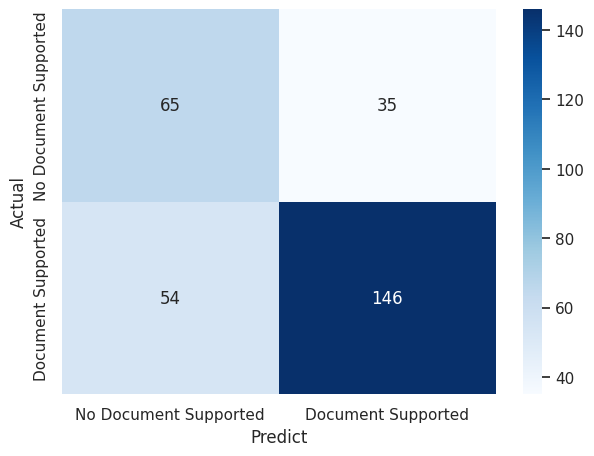

In [127]:
y_pred = max_similarity_scores > optimal_threshold
print(classification_report(y_true=y_true, y_pred=y_pred, digits=4))

plt.figure(figsize=(7, 5))
ax = sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), annot=True, fmt='d', cmap='Blues',
                 xticklabels=['No Document Supported', 'Document Supported'],
                 yticklabels=['No Document Supported', 'Document Supported'])
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

## Reranking

In [128]:
result_df = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = row['question']
    retrieval_results = legal_assistant.retriever.search(text, n=n_documents)
    retrieval = {
        'retrieval_reranking_score': retrieval_results[0]['reranking_score']
    }
    result_df.append(retrieval)
result_df = pd.DataFrame(result_df)
result_df = pd.concat((df, result_df), axis=1)
result_df

100%|██████████| 300/300 [01:21<00:00,  3.66it/s]


,question,law,label,retrieval_reranking_score
0,สัญญาหลักประกันทางธุรกิจต้องเป็นไปตามพระราชบัญ...,พระราชบัญญัติหลักประกันทางธุรกิจ พ.ศ. 2558,0,3.138147e-06
1,การแก้ไขคำสั่งซื้อขายสินทรัพย์ดิจิทัลโดยรู้ว่า...,พระราชกำหนดการประกอบธุรกิจสินทรัพย์ดิจิทัล พ.ศ...,0,2.069838e-07
2,ใครเป็นคนตรวจสอบผู้จัดการกองทุนสำรองเลี้ยงชีพ,พระราชบัญญัติกองทุนสำรองเลี้ยงชีพ พ.ศ. 2530,0,1.929301e-07
3,การจัดให้มีเงินสำรองประเภทต่างๆตามพระราชบัญญัต...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0,9.874638e-07
4,บริษัทหลักทรัพย์ต้องมีทุนจดทะเบียนที่ชำระแล้วเ...,พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. ...,0,1.581260e-05
...,...,...,...,...
295,ในกรณีที่มีการถอนการบังคับคดีนอกจากกรณีตามมาตร...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1,9.941347e-01
296,การล่วงรู้มาตรการป้องกันการเข้าถึงระบบคอมพิวเต...,พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอ...,1,9.999998e-01
297,ผู้ขับขี่รถยนต์ต้องใช้เสียงสัญญาณประเภทใดตามกฎ...,พระราชบัญญัติจราจรทางบก,1,9.999998e-01
298,สามารถยื่นคำฟ้องใหม่ได้หรือไม่หากได้ทิ้งหรือถอ...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง,1,9.946775e-01


In [129]:
result_df[['retrieval_reranking_score']].describe()

,retrieval_reranking_score
count,3.000000e+02
mean,3.390806e-01
std,4.544553e-01
min,1.914287e-07
25%,2.501950e-06
50%,8.041104e-04
75%,9.953875e-01
max,9.999998e-01


In [130]:
result_df.groupby('label')[['retrieval_reranking_score']].describe()

retrieval_reranking_score                                    \
                          count      mean       std           min   
label                                                               
0                         100.0  0.043125  0.184060  1.914287e-07   
1                         200.0  0.487058  0.476904  1.929301e-07   

                                                   
                25%       50%       75%       max  
label                                              
0      2.327182e-07  0.000001  0.000029  0.999878  
1      7.102152e-05  0.384016  0.999996  1.000000

In [131]:
result_df.groupby(['label', 'law'])[['retrieval_reranking_score']].describe()

retrieval_reranking_score  \
                                                                             count   
label law                                                                            
0     พระราชกำหนดการประกอบธุรกิจสินทรัพย์ดิจิทัล พ.ศ....                       5.0   
      พระราชกำหนดนิติบุคคลเฉพาะกิจเพื่อการแปลงสินทรัพ...                       1.0   
      พระราชบัญญัติกองทุนสำรองเลี้ยงชีพ พ.ศ. 2530                              1.0   
      พระราชบัญญัติการบัญชี พ.ศ. 2543                                          1.0   
      พระราชบัญญัติการประกอบกิจการพลังงาน พ.ศ. 2550                           14.0   
      พระราชบัญญัติการประกอบธุรกิจของคนต่างด้าว พ.ศ. ...                       2.0   
      พระราชบัญญัติการส่งเสริมการอนุรักษ์พลังงาน พ.ศ....                       3.0   
      พระราชบัญญัติกำหนดความผิดเกี่ยวกับห้างหุ้นส่วนจ...                       1.0   
      พระราชบัญญัติทรัสต์เพื่อธุรกรรมในตลาดทุน พ.ศ. 2550                       3.0   
      พระราชบัญญัติธุรกิจสถาบันการเงิน พ.ศ. 2551                              10.0   
      พระราชบัญญัติบริษัทมหาชนจำกัด พ.ศ. 2535                                 11.0   
      พระราชบัญญัติภาษีเงินได้ปิโตรเลียม พ.ศ. 2514                             8.0   
      พระราชบัญญัติวิชาชีพบัญชี พ.ศ. 2547                                      4.0   
      พระราชบัญญัติสัญญาซื้อขายล่วงหน้า พ.ศ. 2546                              4.0   
      พระราชบัญญัติหลักทรัพย์และตลาดหลักทรัพย์ พ.ศ. 2535                      22.0   
      พระราชบัญญัติหลักประกันทางธุรกิจ พ.ศ. 2558                               7.0   
      พระราชบัญญัติหอการค้า พ.ศ. 2509                                          3.0   
1     ประมวลกฎหมายยาเสพติด                                                     4.0   
      ประมวลกฎหมายวิธีพิจารณาความอาญา                                         10.0   
      ประมวลกฎหมายวิธีพิจารณาความแพ่ง                                         17.0   
      ประมวลกฎหมายอาญา                                                        11.0   
      ประมวลกฎหมายแพ่งและพาณิชย์                                              79.0   
      ประมวลรัษฎากร                                                           31.0   
      พระราชบัญญัติการขุดดินและถมดิน                                           4.0   
      พระราชบัญญัติการจัดสรรที่ดิน                                             2.0   
      พระราชบัญญัติการเช่าที่ดินเพื่อเกษตรกรรม                                 1.0   
      พระราชบัญญัติคุ้มครองผู้บริโภค                                           1.0   
      พระราชบัญญัติคุ้มครองแรงงาน                                              2.0   
      พระราชบัญญัติจราจรทางบก                                                  6.0   
      พระราชบัญญัติประกันสังคม                                                 2.0   
      พระราชบัญญัติภาษีที่ดินและสิ่งปลูกสร้าง                                  6.0   
      พระราชบัญญัติลิขสิทธิ์                                                   3.0   
      พระราชบัญญัติล้มละลาย                                                    5.0   
      พระราชบัญญัติว่าด้วยการกระทำความผิดเกี่ยวกับคอม...                       1.0   
      พระราชบัญญัติว่าด้วยการปรับเป็นพินัย                                     4.0   
      พระราชบัญญัติว่าด้วยราคาสินค้าและบริการ                                  1.0   
      พระราชบัญญัติศาลเยาวชนและครอบครัวและวิธีพิจารณา...                       3.0   
      พระราชบัญญัติสิทธิบัตร                                                   1.0   
      พระราชบัญญัติเครื่องหมายการค้า                                           2.0   
      พระราชบัญญัติเงินทดแทน                                                   1.0   
      พระราชบัญญัติแรงงานสัมพันธ์                                              3.0   

                                                                        \
                                                                  mean   
label law                                                                
0     พระราชกำหนดการประกอบธุรกิจสินทรัพย์ดิจิทัล พ

In [40]:
best_accuracy = -np.inf
optimal_threshold = None
y_true = result_df['label']
reranking_scores = result_df['retrieval_reranking_score']
for threshold in tqdm(np.arange(0.00001, 0.99999, 0.00001)):
    y_pred = reranking_scores > threshold
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_threshold = threshold
best_accuracy, optimal_threshold

100%|██████████| 99998/99998 [00:54<00:00, 1833.35it/s]


(0.7933333333333333, 1e-05)

In [132]:
best_accuracy = -np.inf
optimal_threshold = None
y_true = result_df['label']
reranking_scores = result_df['retrieval_reranking_score']
for threshold in tqdm(np.arange(0.0000001, 0.0010000, 0.0000001)):
    y_pred = reranking_scores > threshold
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_threshold = threshold
best_accuracy, optimal_threshold

100%|██████████| 9999/9999 [00:05<00:00, 1849.44it/s]


(0.8033333333333333, 3.6999999999999997e-06)

                       precision    recall  f1-score   support

No Document Supported     0.7470    0.6200    0.6776       100
   Document Supported     0.8249    0.8950    0.8585       200

             accuracy                         0.8033       300
            macro avg     0.7859    0.7575    0.7681       300
         weighted avg     0.7989    0.8033    0.7982       300



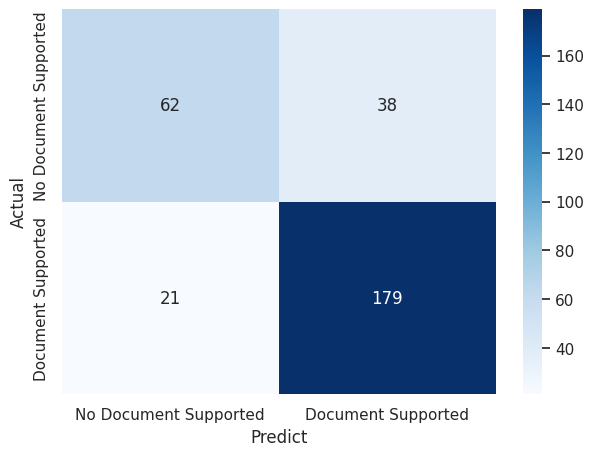

In [135]:
y_pred = reranking_scores > optimal_threshold
print(classification_report(y_true=y_true, y_pred=y_pred, digits=4, target_names=['No Document Supported', 'Document Supported']))

plt.figure(figsize=(7, 5))
ax = sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), annot=True, fmt='d', cmap='Blues',
                 xticklabels=['No Document Supported', 'Document Supported'],
                 yticklabels=['No Document Supported', 'Document Supported'])
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# New Test Dataset 4

In [20]:
df = pd.read_csv('../asset/dataset/new_testdataset_4_v3.csv')
df

,question,answer,Difficult,prompt,label
0,ทำไมท้องฟ้าถึงเป็นสีฟ้า?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทำไมท้องฟ้าถึงเป็นสีฟ้า?,0
1,ดวงจันทร์มีด้านมืดจริงไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ดวงจันทร์มีด้านมืดจริงไหม?,0
2,น้ำแข็งจะแข็งตัวที่อุณหภูมิเท่าไหร่?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,น้ำแข็งจะแข็งตัวที่อุณหภูมิเท่าไหร่?,0
3,ทำไมผึ้งถึงบินได้แม้ปีกเล็กมาก?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทำไมผึ้งถึงบินได้แม้ปีกเล็กมาก?,0
4,ทะเลทรายมีหิมะได้ไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทะเลทรายมีหิมะได้ไหม?,0
...,...,...,...,...,...
395,หากมีเด็กถูกทำร้ายในครอบครัว คนรอบข้างควรทำอย่...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,หากมีเด็กถูกทำร้ายในครอบครัว คนรอบข้างควรทำอย่...,1
396,การฟ้องร้องโดยไม่มีมูลความจริงสามารถทำให้ใครเด...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การฟ้องร้องโดยไม่มีมูลความจริงสามารถทำให้ใครเด...,1
397,การให้สินบนเพื่อให้ได้เปรียบในทางใดทางหนึ่งถือ...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การให้สินบนเพื่อให้ได้เปรียบในทางใดทางหนึ่งถือ...,1
398,การเลือกปฏิบัติระหว่างคนสองคนในสถานการณ์เดียวก...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การเลือกปฏิบัติระหว่างคนสองคนในสถานการณ์เดียวก...,1


In [22]:
legal_assistant.domain_detector('ทดสอบ', return_prob=False)

False

In [41]:
result_df = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    domain_detection_start = time.time()
    text = row['question']
    legal_domain, legal_domain_prob = legal_assistant.domain_detector(text, return_prob=True)
    domain_detection_end = time.time()
    domain_detection = {
        'domain_detection_result': legal_domain,
        'domain_detection_prob': legal_domain_prob,
        'domain_detection_time_usage': domain_detection_end - domain_detection_start
    }
    result_df.append(domain_detection)
result_df = pd.DataFrame(result_df)
result_df = pd.concat((df, result_df), axis=1)
result_df

100%|██████████| 400/400 [00:02<00:00, 181.80it/s]


,question,answer,Difficult,prompt,label,domain_detection_result,domain_detection_prob,domain_detection_time_usage
0,ทำไมท้องฟ้าถึงเป็นสีฟ้า?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทำไมท้องฟ้าถึงเป็นสีฟ้า?,0,False,0.000359,0.007367
1,ดวงจันทร์มีด้านมืดจริงไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ดวงจันทร์มีด้านมืดจริงไหม?,0,False,0.000353,0.006225
2,น้ำแข็งจะแข็งตัวที่อุณหภูมิเท่าไหร่?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,น้ำแข็งจะแข็งตัวที่อุณหภูมิเท่าไหร่?,0,False,0.000362,0.005823
3,ทำไมผึ้งถึงบินได้แม้ปีกเล็กมาก?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทำไมผึ้งถึงบินได้แม้ปีกเล็กมาก?,0,False,0.000374,0.005252
4,ทะเลทรายมีหิมะได้ไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Easy,ทะเลทรายมีหิมะได้ไหม?,0,False,0.000383,0.005996
...,...,...,...,...,...,...,...,...
395,หากมีเด็กถูกทำร้ายในครอบครัว คนรอบข้างควรทำอย่...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,หากมีเด็กถูกทำร้ายในครอบครัว คนรอบข้างควรทำอย่...,1,True,0.999759,0.006178
396,การฟ้องร้องโดยไม่มีมูลความจริงสามารถทำให้ใครเด...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การฟ้องร้องโดยไม่มีมูลความจริงสามารถทำให้ใครเด...,1,True,0.999816,0.006097
397,การให้สินบนเพื่อให้ได้เปรียบในทางใดทางหนึ่งถือ...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การให้สินบนเพื่อให้ได้เปรียบในทางใดทางหนึ่งถือ...,1,True,0.999803,0.006034
398,การเลือกปฏิบัติระหว่างคนสองคนในสถานการณ์เดียวก...,คำถามนี้เกี่ยวข้องกับกฎหมาย,Hard,การเลือกปฏิบัติระหว่างคนสองคนในสถานการณ์เดียวก...,1,True,0.999741,0.005962


In [42]:
def evaluate_domain_detection(y_true, y_pred):
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Out of Legal Domain', 'In Legal Domain'],
                                digits=4))
    
    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), annot=True, fmt='d', cmap='Blues',
                     xticklabels=['Out of Legal Domain', 'In Legal Domain'],
                     yticklabels=['Out of Legal Domain', 'In Legal Domain'])
    ax.set(xlabel='Predict', ylabel='Actual')
    plt.show()

Overall:
                     precision    recall  f1-score   support

Out of Legal Domain     0.9128    0.7850    0.8441       200
    In Legal Domain     0.8114    0.9250    0.8645       200

           accuracy                         0.8550       400
          macro avg     0.8621    0.8550    0.8543       400
       weighted avg     0.8621    0.8550    0.8543       400



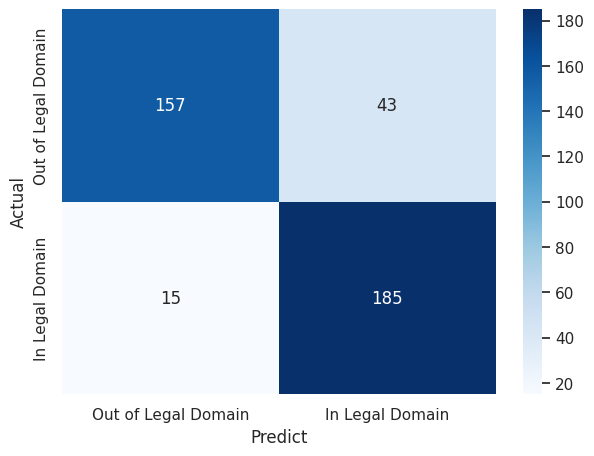



Easy:
                     precision    recall  f1-score   support

Out of Legal Domain     0.9346    1.0000    0.9662       100
    In Legal Domain     1.0000    0.9300    0.9637       100

           accuracy                         0.9650       200
          macro avg     0.9673    0.9650    0.9650       200
       weighted avg     0.9673    0.9650    0.9650       200



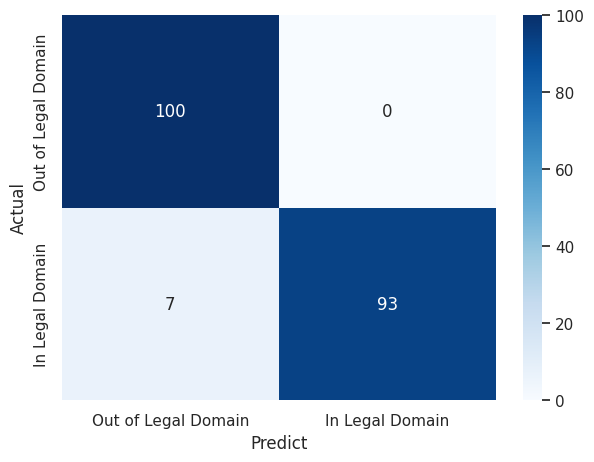



Hard:
                     precision    recall  f1-score   support

Out of Legal Domain     0.8769    0.5700    0.6909       100
    In Legal Domain     0.6815    0.9200    0.7830       100

           accuracy                         0.7450       200
          macro avg     0.7792    0.7450    0.7369       200
       weighted avg     0.7792    0.7450    0.7369       200



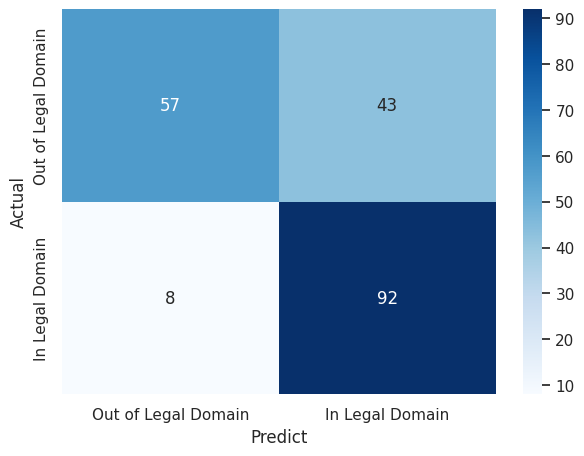

In [43]:
print('Overall:')
evaluate_domain_detection(y_true=result_df['label'], y_pred=result_df['domain_detection_result'])
print('\n')
print('Easy:')
evaluate_domain_detection(y_true=result_df.query('Difficult == "Easy"')['label'],
                          y_pred=result_df.query('Difficult == "Easy"')['domain_detection_result'])
print('\n')
print('Hard:')
evaluate_domain_detection(y_true=result_df.query('Difficult == "Hard"')['label'],
                          y_pred=result_df.query('Difficult == "Hard"')['domain_detection_result'])

In [44]:
display(result_df.query('Difficult == "Hard" and ~label and domain_detection_result').sample(10, random_state=0))
result_df.query('Difficult == "Hard" and ~label and domain_detection_result').sample(10, random_state=0)['question'].tolist()

,question,answer,Difficult,prompt,label,domain_detection_result,domain_detection_prob,domain_detection_time_usage
269,ถ้าโดนฟ้องว่าไม่ดูแลตัวเอง คุณจะว่าไง?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้าโดนฟ้องว่าไม่ดูแลตัวเอง คุณจะว่าไง?,0,True,0.999812,0.005178
285,คุณเคยฟ้องใครในใจแต่ไม่กล้าบอกไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,คุณเคยฟ้องใครในใจแต่ไม่กล้าบอกไหม?,0,True,0.999792,0.005477
262,ถ้ามีร่างกฎหมายบังคับให้ชมตัวเองวันละครั้ง จะเ...,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีร่างกฎหมายบังคับให้ชมตัวเองวันละครั้ง จะเ...,0,True,0.999786,0.005215
210,ถ้ามีร่างกฎหมายบังคับให้คนเลี้ยงแมว คุณจะเห็นด...,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีร่างกฎหมายบังคับให้คนเลี้ยงแมว คุณจะเห็นด...,0,True,0.996549,0.005197
220,ถ้ามีร่างกฎหมายบังคับให้เที่ยวปีละ 2 ครั้ง คุณ...,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีร่างกฎหมายบังคับให้เที่ยวปีละ 2 ครั้ง คุณ...,0,True,0.999814,0.005094
259,ถ้าจำเลยคือความกังวล จะมีใครมาเป็นพยานให้คุณ?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้าจำเลยคือความกังวล จะมีใครมาเป็นพยานให้คุณ?,0,True,0.902211,0.005189
264,คุณเคยรู้สึกว่าชีวิตคือคดีที่ไม่มีวันปิดไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,คุณเคยรู้สึกว่าชีวิตคือคดีที่ไม่มีวันปิดไหม?,0,True,0.954219,0.005862
224,ถ้ามีศาลแห่งความฝัน คุณอยากยื่นคำร้องเรื่องอะไร?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีศาลแห่งความฝัน คุณอยากยื่นคำร้องเรื่องอะไร?,0,True,0.999770,0.005200
290,ถ้ามีคดีว่าคุณมีความสุขมากไป คุณจะสารภาพไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีคดีว่าคุณมีความสุขมากไป คุณจะสารภาพไหม?,0,True,0.998442,0.005180
271,ถ้ามีศาลแห่งการให้อภัย คุณอยากพาใครไปขึ้นศาล?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้ามีศาลแห่งการให้อภัย คุณอยากพาใครไปขึ้นศาล?,0,True,0.999816,0.005079


['ถ้าโดนฟ้องว่าไม่ดูแลตัวเอง คุณจะว่าไง?',
 'คุณเคยฟ้องใครในใจแต่ไม่กล้าบอกไหม?',
 'ถ้ามีร่างกฎหมายบังคับให้ชมตัวเองวันละครั้ง จะเป็นยังไง?',
 'ถ้ามีร่างกฎหมายบังคับให้คนเลี้ยงแมว คุณจะเห็นด้วยไหม?',
 'ถ้ามีร่างกฎหมายบังคับให้เที่ยวปีละ 2 ครั้ง คุณจะสนับสนุนไหม?',
 'ถ้าจำเลยคือความกังวล จะมีใครมาเป็นพยานให้คุณ?',
 'คุณเคยรู้สึกว่าชีวิตคือคดีที่ไม่มีวันปิดไหม?',
 'ถ้ามีศาลแห่งความฝัน คุณอยากยื่นคำร้องเรื่องอะไร?',
 'ถ้ามีคดีว่าคุณมีความสุขมากไป คุณจะสารภาพไหม?',
 'ถ้ามีศาลแห่งการให้อภัย คุณอยากพาใครไปขึ้นศาล?']

In [45]:
display(result_df.query('Difficult == "Hard" and ~label and ~domain_detection_result').sample(10, random_state=0))
result_df.query('Difficult == "Hard" and ~label and ~domain_detection_result').sample(10, random_state=0)['question'].tolist()

,question,answer,Difficult,prompt,label,domain_detection_result,domain_detection_prob,domain_detection_time_usage
263,ใครคือพยานในวันที่คุณยิ้มมากที่สุด?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ใครคือพยานในวันที่คุณยิ้มมากที่สุด?,0,False,0.000466,0.005270
260,คุณเคยละเมิดกฎของหัวใจไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,คุณเคยละเมิดกฎของหัวใจไหม?,0,False,0.009637,0.005169
273,ใครคือพยานในวันที่คุณล้มเหลวแล้วลุกขึ้นได้?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ใครคือพยานในวันที่คุณล้มเหลวแล้วลุกขึ้นได้?,0,False,0.008761,0.005198
247,ถ้าต้องมีคำพิพากษาให้รักตัวเองมากขึ้น จะดีไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้าต้องมีคำพิพากษาให้รักตัวเองมากขึ้น จะดีไหม?,0,False,0.447005,0.005215
222,ใครคือจำเลยเวลารีโมตทีวีหาย?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ใครคือจำเลยเวลารีโมตทีวีหาย?,0,False,0.000350,0.005199
203,หลักฐานอะไรที่แสดงว่าคุณรักกาแฟมากที่สุด?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,หลักฐานอะไรที่แสดงว่าคุณรักกาแฟมากที่สุด?,0,False,0.000375,0.005201
256,ถ้าความเบื่อคือโจทก์ คุณจะต่อสู้ยังไง?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้าความเบื่อคือโจทก์ คุณจะต่อสู้ยังไง?,0,False,0.000371,0.005262
298,ถ้าจำเลยคืออดีตของคุณ คุณจะให้อภัยไหม?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,ถ้าจำเลยคืออดีตของคุณ คุณจะให้อภัยไหม?,0,False,0.000978,0.005176
238,จำเลยในเรื่องสุขภาพของคุณคืออะไร?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,จำเลยในเรื่องสุขภาพของคุณคืออะไร?,0,False,0.000366,0.005846
297,หลักฐานสุดท้ายที่แสดงว่าคุณยังรักใครบางคนคืออะไร?,ขออภัยคำถามของคุณไม่ได้เกี่ยวข้องกับกฎหมาย,Hard,หลักฐานสุดท้ายที่แสดงว่าคุณยังรักใครบางคนคืออะไร?,0,False,0.001346,0.005162


['ใครคือพยานในวันที่คุณยิ้มมากที่สุด?',
 'คุณเคยละเมิดกฎของหัวใจไหม?',
 'ใครคือพยานในวันที่คุณล้มเหลวแล้วลุกขึ้นได้?',
 'ถ้าต้องมีคำพิพากษาให้รักตัวเองมากขึ้น จะดีไหม?',
 'ใครคือจำเลยเวลารีโมตทีวีหาย?',
 'หลักฐานอะไรที่แสดงว่าคุณรักกาแฟมากที่สุด?',
 'ถ้าความเบื่อคือโจทก์ คุณจะต่อสู้ยังไง?',
 'ถ้าจำเลยคืออดีตของคุณ คุณจะให้อภัยไหม?',
 'จำเลยในเรื่องสุขภาพของคุณคืออะไร?',
 'หลักฐานสุดท้ายที่แสดงว่าคุณยังรักใครบางคนคืออะไร?']

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

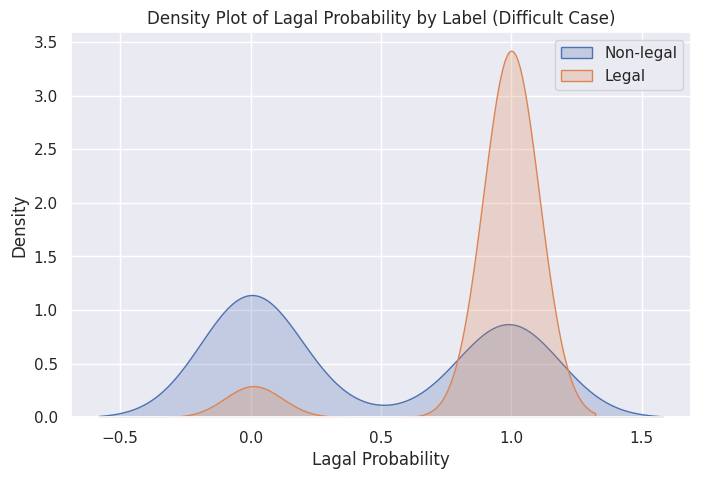

In [64]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=result_df.query('Difficult == "Hard" and ~label'),
            x='domain_detection_prob', label='Non-legal', fill=True)
sns.kdeplot(data=result_df.query('Difficult == "Hard" and label'),
            x='domain_detection_prob', label='Legal', fill=True)
plt.title('Density Plot of Lagal Probability by Label (Difficult Case)')
plt.xlabel('Lagal Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()